# Full Prediction

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import StackingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm
from lightgbm import LGBMRegressor

In [2]:
import dill
import pickle

In [3]:
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="X does not have valid feature names")
warnings.filterwarnings("ignore", message="DataFrame.fillna with 'method' is deprecated")
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [4]:
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 

In [5]:
tqdm.pandas()

## Load Data

In [6]:
input_2023 = pd.read_csv(f'../data/folds/fold1/VALIDATION_input.csv')

In [7]:
output_2023 = pd.read_csv(f'../data/folds/fold1/VALIDATION_output.csv')

In [8]:
input_2023.shape

(974917, 24)

In [9]:
output_2023.shape

(111919, 7)

## Standardize XY Positions

In [10]:
def standardize_by_play_direction(df: pd.DataFrame):
    # Standardize X-Y Position
    df.loc[df['play_direction'] == 'left', 'x'] = 120 - df['x']
    df.loc[df['play_direction'] == 'left', 'ball_land_x'] = 120 - df['ball_land_x']
    df.loc[df['play_direction'] == 'left', 'y'] = 53.3 - df['y']
    df.loc[df['play_direction'] == 'left', 'ball_land_y'] = 53.3 - df['ball_land_y']
    
    # Standardize 'dir' and 'o' angles
    df.loc[df['play_direction'] == 'left', 'dir'] = (df['dir'] + 180) % 360
    df.loc[df['play_direction'] == 'left', 'o'] = (df['o'] + 180) % 360
    
    return df

In [11]:
std_df = standardize_by_play_direction(input_2023)

In [12]:
std_df.shape

(974917, 24)

## Engineer Features

In [13]:
def vectorize_kinematics(df: pd.DataFrame):
    groups = ['game_id', 'play_id', 'nfl_id']

    df['x_shift'] = df.groupby(groups)['x'].shift(1)
    df['y_shift'] = df.groupby(groups)['y'].shift(1)

    df['velocity_x'] = (df['x'] - df['x_shift']) / 0.1
    df['velocity_y'] = (df['y'] - df['y_shift']) / 0.1

    df['acc_x'] = df.groupby(groups)['velocity_x'].diff() / 0.1
    df['acc_y'] = df.groupby(groups)['velocity_y'].diff() / 0.1

    return df

In [14]:
def calculate_land_spot_bearing(df: pd.DataFrame):
    # Receiver angle to landing spot
    df['land_spot_dir'] = np.degrees(np.arctan2(
        df['ball_land_y'] - df['y'],
        df['ball_land_x'] - df['x']
    )) % 360
    
    # xy components for angle to landing spot
    df['land_spot_dirx'] = np.cos(np.radians(df['land_spot_dir']))
    df['land_spot_diry'] = np.sin(np.radians(df['land_spot_dir']))
    
    # landing spot distance
    df['land_spot_dist'] = np.sqrt(
        (df['ball_land_x'] - df['x'])**2 + (df['ball_land_y'] - df['y'])**2
    )
    
    return df

In [15]:
def calculate_field_distances(df: pd.DataFrame):
    # Distance from top
    df['dist_sideline'] = 53.3 - df['y']
    
    # Distance to nearest endzone
    df['dist_endzone'] = 120 - df['x']
    
    return df

In [82]:
def get_closest_defender_bearing(df: pd.DataFrame):
    def closest(group: pd.DataFrame):
        # exactly 1 offensive player
        off = group[group['player_role'] == 'Targeted Receiver'].iloc[0]

        # all defenders
        defs = group[group['player_side'] == 'Defense']

        if defs.empty:
            return pd.DataFrame({
                'nfl_id': off.nfl_id,
                'closest_def_id': [-1],
                'closest_def_dist': [0],
                'closest_def_dir_x': [0],
                'closest_def_dir_y': [0]
            })

        # Get x, y directions from offense to each defender
        closest_def_dir = np.degrees(np.arctan2(defs['y'] - off['y'], defs['x'] - off['x'])) % 360
        closest_def_dir_x = np.cos(np.radians(closest_def_dir))
        closest_def_dir_y = np.sin(np.radians(closest_def_dir))
        
        # compute Euclidean distances
        closest_def_dist = np.sqrt((defs['x'] - off['x'])**2 + (defs['y'] - off['y'])**2)

        # index of defender with min distance
        idxmin = closest_def_dist.idxmin()
        
        return pd.DataFrame([{
            'nfl_id': off.nfl_id,
            'closest_def_id': defs.loc[idxmin, 'nfl_id'],
            'closest_def_dist': closest_def_dist.loc[idxmin],
            'closest_def_dir_x': closest_def_dir_x.loc[idxmin],
            'closest_def_dir_y': closest_def_dir_y.loc[idxmin]
        }])

    result = (
        df.groupby(['game_id', 'play_id', 'frame_id', 'source'])
        .apply(closest)
        .reset_index()
    )
    
    # Merge back to original dataframe
    merged = df.merge(
        result,
        on=['game_id', 'play_id', 'frame_id', 'source', 'nfl_id'],
        how='left',
        suffixes=['', '_y']
    )

    # Identify offense rows
    mask = df['player_side'] == 'Offense'

    # Keep merged values only for offense rows
    for col in result.columns:
        if col not in ['game_id', 'play_id', 'frame_id', 'source', 'nfl_id']:
            merged[col] = merged[col].where(mask)
    
    return merged

In [83]:
def get_closest_defender_kinematics(df: pd.DataFrame):
    def closest(group: pd.DataFrame):
        # exactly 1 offensive player
        off = group[group['player_role'] == 'Targeted Receiver'].iloc[0]

        # all defenders
        defs = group[group['player_side'] == 'Defense']

        if defs.empty:
            return pd.DataFrame({
                'nfl_id': off.nfl_id,
                'closest_def_id': [-1],
                'closest_def_velo_x': [0],
                'closest_def_velo_y': [0],
                'closest_def_acc_x': [0],
                'closest_def_acc_y': [0]
            })
        
        # Get velocities and acceleration
        closest_def_velo_x, closest_def_velo_y = defs['velocity_x'], defs['velocity_y']
        closest_def_acc_x, closest_def_acc_y = defs['acc_x'], defs['acc_y']
        
        # compute Euclidean distances
        closest_def_dist = np.sqrt((defs['x'] - off['x'])**2 + (defs['y'] - off['y'])**2)
        
        # index of defender with min distance
        idxmin = closest_def_dist.idxmin()
        
        return pd.DataFrame([{
            'nfl_id': off.nfl_id,
            'closest_def_id': defs.loc[idxmin, 'nfl_id'],
            'closest_def_velo_x': closest_def_velo_x.loc[idxmin],
            'closest_def_velo_y': closest_def_velo_y.loc[idxmin],
            'closest_def_acc_x': closest_def_acc_x.loc[idxmin],
            'closest_def_acc_y': closest_def_acc_y.loc[idxmin]
        }])
        
    
    result = (
        df.groupby(['game_id', 'play_id', 'frame_id', 'source'])
        .apply(closest)
        .reset_index()
    )
    
    # Merge back to original dataframe
    merged = df.merge(
        result,
        on=['game_id', 'play_id', 'frame_id', 'source', 'nfl_id'],
        how='left',
        suffixes=['', '_y']
    )
    
    # Identify offense rows
    mask = df['player_side'] == 'Offense'

    # Keep merged values only for offense rows
    for col in result.columns:
        if col not in ['game_id', 'play_id', 'frame_id', 'source', 'nfl_id']:
            merged[col] = merged[col].where(mask)
    
    return merged

In [18]:
def get_receiver_bearing(df: pd.DataFrame):
    off = (
        df[df['player_role'] == 'Targeted Receiver']
        [['game_id', 'play_id', 'frame_id', 'source', 'player_side', 'nfl_id', 'x', 'y']]
    )
    
    defs = df[df['player_side'] == 'Defense']
    
    df2 = defs.merge(
        off,
        on=['game_id', 'play_id', 'frame_id', 'source'],
        how='left',
        suffixes=('', '_off')
    )
    
    # Get x, y directions from defender to receiver
    receiver_dir = np.degrees(np.arctan2(df2['y_off'] - df2['y'], df2['x_off'] - df2['x'])) % 360
    receiver_dir_x = np.cos(np.radians(receiver_dir))
    receiver_dir_y = np.sin(np.radians(receiver_dir))
    
    # Calculate receiver distance
    df2['receiver_dist'] = np.sqrt(
        (df2['x'] - df2['x_off'])**2 +
        (df2['y'] - df2['y_off'])**2
    )
    
    result = df2[['game_id', 'play_id', 'frame_id', 'source', 'nfl_id', 'receiver_dist']].copy()
    result['receiver_dir_x'] = receiver_dir_x
    result['receiver_dir_y'] = receiver_dir_y
    
    merged = df.merge(
        result,
        on=['game_id', 'play_id', 'frame_id', 'source', 'nfl_id'],
        how='left',
        suffixes=['', '_y']
    )
    
    return merged

In [19]:
def get_receiver_kinematics(df: pd.DataFrame):
    off = (
        df[df['player_role'] == 'Targeted Receiver']
        [['game_id', 'play_id', 'frame_id', 
          'source', 'player_side', 'nfl_id', 
          'velocity_x', 'velocity_y',
          'acc_x', 'acc_y'
        ]]
    )
    
    defs = df[df['player_side'] == 'Defense']
    
    df2 = defs.merge(
        off,
        on=['game_id', 'play_id', 'frame_id', 'source'],
        how='left',
        suffixes=('', '_off')
    )
    
    result = df2[['game_id', 'play_id', 'frame_id', 'source', 'nfl_id', 'velocity_x_off', 'velocity_y_off', 'acc_x_off', 'acc_y_off']]
    
    merged = df.merge(
        result,
        on=['game_id', 'play_id', 'frame_id', 'source', 'nfl_id'],
        how='left',
        suffixes=['', '_y']
    )
    
    return merged

In [38]:
def calculate_throw_stats(df):
    # NOTE: There are some plays where QB is not specified in the data
    #       therefore, the throw stats will be NA. For those, we fillna(0)
    # Create a small df with throw distance and throw velocity per game_id, play_id
    qb_df = df[df['player_position'] == 'QB']
    qb_df = qb_df.drop_duplicates(subset=['game_id', 'play_id'], keep='last')
    
    qb_df['throw_distance'] = np.sqrt((qb_df['ball_land_x'] - qb_df['x'])**2 + (qb_df['ball_land_y'] - qb_df['y'])**2)
    qb_df['throw_velocity'] = qb_df['throw_distance'] / (qb_df['num_frames_output'] / 10)
    throw_stats_df = qb_df[['game_id', 'play_id', 'throw_distance', 'throw_velocity']]
    
    return throw_stats_df

In [21]:
throw_stats = calculate_throw_stats(std_df)

In [22]:
# We only use those who needs prediction
std_df_subset = std_df[std_df['player_to_predict'] == True].reset_index(drop=True)

In [23]:
eng_df = std_df_subset.copy()
eng_df['source'] = 'input'

In [24]:
eng_df = vectorize_kinematics(eng_df)

In [25]:
eng_df = calculate_field_distances(eng_df)

In [26]:
eng_df = calculate_land_spot_bearing(eng_df)

In [27]:
eng_df = get_closest_defender_bearing(eng_df).drop(['level_4', 0], axis=1, errors='ignore')  # Where does this 0 column come from???

  0%|          | 0/79228 [00:00<?, ?it/s]

In [28]:
eng_df.shape

(258411, 41)

In [29]:
eng_df = get_closest_defender_kinematics(eng_df).drop(['level_4', 0], axis=1, errors='ignore')  # Where does this 0 column come from???

  0%|          | 0/79228 [00:00<?, ?it/s]

In [30]:
eng_df.shape

(258411, 46)

In [31]:
eng_df = get_receiver_bearing(eng_df)

In [32]:
eng_df = get_receiver_kinematics(eng_df)

In [33]:
eng_df = eng_df.merge(throw_stats, on=['game_id', 'play_id'], how='left')

Quick inspect

In [34]:
eng_df.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,week,source,x_shift,y_shift,velocity_x,velocity_y,acc_x,acc_y,dist_sideline,dist_endzone,land_spot_dir,land_spot_dirx,land_spot_diry,land_spot_dist,closest_def_id,closest_def_dist,closest_def_dir_x,closest_def_dir_y,closest_def_id_y,closest_def_velo_x,closest_def_velo_y,closest_def_acc_x,closest_def_acc_y,receiver_dist,receiver_dir_x,receiver_dir_y,velocity_x_off,velocity_y_off,acc_x_off,acc_y_off,throw_distance,throw_velocity
0,2023090700,877,True,47888,1,right,71,C.J. Gardner-Johnson,5-11,208,1997-12-20,SS,Defense,Defensive Coverage,80.48,18.72,1.19,0.24,98.97,277.48,10,83.059998,17.709999,w01,input,NaN,NaN,NaN,NaN,NaN,NaN,34.58,39.52,338.620969,0.931189,-0.364536,2.770648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.391384,-0.847363,-0.531014,NaN,NaN,NaN,NaN,22.304814,22.304814
1,2023090700,877,True,47888,2,right,71,C.J. Gardner-Johnson,5-11,208,1997-12-20,SS,Defense,Defensive Coverage,80.59,18.70,1.17,0.21,98.83,277.48,10,83.059998,17.709999,w01,input,80.48,18.72,1.1,-0.2,NaN,NaN,34.60,39.41,338.158570,0.928217,-0.372039,2.661013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.460437,-0.850692,-0.525664,0.1,0.1,NaN,NaN,22.304814,22.304814
2,2023090700,877,True,47888,3,right,71,C.J. Gardner-Johnson,5-11,208,1997-12-20,SS,Defense,Defensive Coverage,80.71,18.67,1.21,0.26,102.84,275.88,10,83.059998,17.709999,w01,input,80.59,18.70,1.2,-0.3,1.0,-1.000000e+00,34.63,39.29,337.779423,0.925735,-0.378173,2.538521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.524779,-0.854306,-0.519770,0.2,0.1,1.0,0.0,22.304814,22.304814
3,2023090700,877,True,47888,4,right,71,C.J. Gardner-Johnson,5-11,208,1997-12-20,SS,Defense,Defensive Coverage,80.84,18.64,1.36,0.49,103.17,273.97,10,83.059998,17.709999,w01,input,80.71,18.67,1.3,-0.3,1.0,-3.552714e-13,34.66,39.16,337.270225,0.922337,-0.386385,2.406926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.606875,-0.858262,-0.513212,0.1,0.1,-1.0,0.0,22.304814,22.304814
4,2023090700,877,True,47888,5,right,71,C.J. Gardner-Johnson,5-11,208,1997-12-20,SS,Defense,Defensive Coverage,80.98,18.61,1.48,0.66,104.47,271.42,10,83.059998,17.709999,w01,input,80.84,18.64,1.4,-0.3,1.0,0.000000e+00,34.69,39.02,336.602190,0.917770,-0.397113,2.266361,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.645082,-0.861995,-0.506916,0.6,0.3,5.0,2.0,22.304814,22.304814


In [35]:
# Check if there are NAs in Offense features related to closest defender
eng_df[(eng_df.player_side == 'Offense') & (eng_df[['closest_def_id']].isnull().any(axis=1))].shape

(0, 55)

In [36]:
# Check if there are NAs in Defense features related to receiver
eng_df[(eng_df.player_side == 'Defense') & (eng_df[['receiver_dist']].isnull().any(axis=1))].shape

(0, 55)

In [39]:
# Check if any of throw stats is NA
eng_df[eng_df[['throw_distance', 'throw_velocity']].isnull().any(axis=1)].shape

(152, 55)

Fill NAs in throw stats

In [40]:
eng_df.fillna(0, inplace=True)

## Prediction

Load models and scalers from generated from `full_training.ipynb`.

In [43]:
with open('training_saved_session/off_model.pkl', 'rb') as f:
    off_model = pickle.load(f)

In [45]:
with open('training_saved_session/off_scaling.pkl', 'rb') as f:
    off_scaler = pickle.load(f)

In [46]:
with open('training_saved_session/def_model.pkl', 'rb') as f:
    def_model = pickle.load(f)

In [47]:
with open('training_saved_session/def_scaling.pkl', 'rb') as f:
    def_scaler = pickle.load(f)

Define functions used to predict output

In [70]:
def select_x_features(df: pd.DataFrame, off_or_def: str):
    base_features = [
        'velocity_x', 'velocity_y',
        'acc_x', 'acc_y',
        'land_spot_dirx', 'land_spot_diry', 'land_spot_dist',
        'dist_sideline', 'dist_endzone',
        'throw_distance', 'throw_velocity',
    ]
    
    offense_features = [
        'closest_def_dist', 'closest_def_dir_x', 'closest_def_dir_y',
        'closest_def_velo_x', 'closest_def_velo_y',
        'closest_def_acc_x', 'closest_def_acc_y'
    ]
    
    defense_features = [
        'receiver_dist', 'receiver_dir_x', 'receiver_dir_y',
        'velocity_x_off', 'velocity_y_off',
        'acc_x_off', 'acc_y_off'
    ]
    
    if off_or_def == 'offense':
        feature_cols = base_features + offense_features
    else:
        feature_cols = base_features + defense_features
        
    X = df[feature_cols]
    
    return X

In [72]:
def apply_same_scaling(X: pd.DataFrame, y: pd.DataFrame, scaler_motion, scaler_others):
    motion_vars = ['velocity_x', 'velocity_y', 'acc_x', 'acc_y']
    other_vars = [col for col in X.columns if col not in motion_vars]
    
    # Apply scaling
    X_motion_scaled = pd.DataFrame(scaler_motion.transform(X[motion_vars]), columns=motion_vars)
    X_others_scaled = pd.DataFrame(scaler_others.transform(X[other_vars]), columns=other_vars)
    
    # Recombine scaled X
    X_scaled = pd.concat([X_motion_scaled, X_others_scaled], axis=1)
    
    # Apply scaling to y as well; Use same scaler as motion features
    y = y.rename(columns={
        'velocity_x_shift': 'velocity_x',
        'velocity_y_shift': 'velocity_y',
        'acceleration_x_shift': 'acc_x',
        'acceleration_y_shift': 'acc_y'
    })
    
    y_scaled = pd.DataFrame(scaler_motion.transform(y), columns=y.columns)  # use same scaler as motion features for the values to be predicted
    
    return X_scaled, y_scaled

In [74]:
def calculate_new_pos(row):
    x_new = row['x'] + row['velocity_x_pred']*0.1 + 0.5*row['acc_x_pred']*0.01
    y_new = row['y'] + row['velocity_y_pred']*0.1 + 0.5*row['acc_y_pred']*0.01
    
    return x_new, y_new

In [76]:
def predict_next_frame(frame: pd.DataFrame):
    def parse_frame(df: pd.DataFrame, off_or_def: str):
        # Select scaler and model
        if off_or_def == 'offense':
            scaler = off_scaler
            model = off_model
        else:
            scaler = def_scaler
            model = def_model
            
        X = select_x_features(df, off_or_def)
        dummy_df = pd.DataFrame({
            'velocity_x_shift': [0], 
            'velocity_y_shift': [0], 
            'acceleration_x_shift': [0], 
            'acceleration_y_shift': [0]
        })  # Dummy for scaling function
            
        # Scale
        X_scaled, _ = apply_same_scaling(
            X, dummy_df,
            scaler['scaler_motion'],
            scaler['scaler_others']
        )
        
        # Select model
        pred = model.predict(X_scaled)
        
        # Inverse transform
        pred = scaler['scaler_motion'].inverse_transform(pred)
        
        # Get x and y components
        df['velocity_x_pred'], df['velocity_y_pred'] = pred[:, 0], pred[:, 1]
        df['acc_x_pred'], df['acc_y_pred'] = pred[:, 2], pred[:, 3]
        
        # Calculate new position
        pred_xy = df.apply(calculate_new_pos, axis=1)
        df['x_pred'], df['y_pred'] = zip(*pred_xy)
        
        return df
        
    frame_off = frame[frame.player_side == 'Offense'].reset_index(drop=True)
    frame_def = frame[frame.player_side == 'Defense'].reset_index(drop=True)
    
    if (not frame_off.empty) and (not frame_def.empty):
        frame_off = parse_frame(frame_off, 'offense')
        frame_def = parse_frame(frame_def, 'defense')
        
        out_frame = pd.concat([frame_off, frame_def], ignore_index=True)
    elif not frame_off.empty:
        out_frame = parse_frame(frame_off, 'offense')
    elif not frame_def.empty:
        out_frame = parse_frame(frame_def, 'defense')
    else:
        print(frame)
        raise ValueError('Both offense and defense sub-frames are empty!')
    
    # New frame / row
    new_frame = pd.DataFrame({
        'game_id': out_frame.game_id,
        'play_id': out_frame.play_id,
        'nfl_id': out_frame.nfl_id,
        'source': 'output',
        'x': out_frame.x_pred,
        'y': out_frame.y_pred,
        'throw_velocity': out_frame.throw_velocity,
        'throw_distance': out_frame.throw_distance,
        'ball_land_x': out_frame.ball_land_x,
        'ball_land_y': out_frame.ball_land_y,
        'player_role': out_frame.player_role,
        'player_side': out_frame.player_side,
        'velocity_x': out_frame.velocity_x_pred,
        'velocity_y': out_frame.velocity_y_pred,
        'acc_x': out_frame.acc_x_pred,
        'acc_y': out_frame.acc_y_pred
    })
    
    return new_frame

In [78]:
def calculate_features(frame: pd.DataFrame):
    current_frame = calculate_land_spot_bearing(frame)
    current_frame = calculate_field_distances(current_frame)
    current_frame = get_closest_defender_bearing(current_frame)
    current_frame = get_closest_defender_kinematics(current_frame)
    current_frame = get_receiver_bearing(current_frame)
    current_frame = get_receiver_kinematics(current_frame)
    current_frame.fillna(0, inplace=True)
    
    return current_frame

In [84]:
def predict_all_frames(df: pd.DataFrame):
    def predict_frame_by_frame(g):
        input_cols = [
            'game_id', 'play_id', 'nfl_id', 
            'frame_id', 'source', 'x', 'y', 
            'ball_land_x', 'ball_land_y', 'player_role', 
            'player_side', 'velocity_x', 'velocity_y', 
            'acc_x', 'acc_y', 'throw_distance', 'throw_velocity'
        ]
        final_df = g[g.frame_id == 0].copy()
        frames_to_pred = g.num_frames_output.values[0]
        frame_range = range(1, frames_to_pred + 1)
        
        for f in frame_range:
            try:
                if f == 1:  # Use calculated features from frame_id == 0
                    current_frame = final_df[final_df.frame_id == f-1].copy()
                    next_frame = predict_next_frame(current_frame)
                else:
                    current_frame = final_df[final_df.frame_id == f-1][input_cols].copy()  # Need to subset since new columns will be added by `calculate_features`
                    current_frame = calculate_features(current_frame)
                    next_frame = predict_next_frame(current_frame)
            except:
                print(f'Skipping - Game ID: {current_frame.game_id.values}, Play ID: {current_frame.play_id.values}, Frame Number: {f}')
                print(g)
                raise ValueError('SOMETHING WENT WRONG WAAAAAH!')

            next_frame['frame_id'] = f
            final_df = pd.concat([final_df, next_frame]).reset_index(drop=True)
        
        return final_df
            
    result = (
        df.groupby(['game_id', 'play_id'])
        .progress_apply(predict_frame_by_frame)
        .reset_index(drop=True)
    )
    
    return result

Get last input frame

In [63]:
def reduce_df(df: pd.DataFrame):
    # Get all frames in output and last frame of input
    df = df[((df.source == 'input') & (df.frame_id == df[df.source == 'input'].frame_id.max()))]
    df.loc[df.source == 'input', 'frame_id'] = 0
    
    return df

In [64]:
input_last_frame = eng_df.groupby(['game_id', 'play_id', 'nfl_id']).apply(reduce_df).reset_index(drop=True)

In [133]:
input_last_frame[(input_last_frame.game_id == 2023090700) & (input_last_frame.play_id == 1154) & (input_last_frame.nfl_id == 53541)]

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,week,source,x_shift,y_shift,velocity_x,velocity_y,acc_x,acc_y,dist_sideline,dist_endzone,land_spot_dir,land_spot_dirx,land_spot_diry,land_spot_dist,closest_def_id,closest_def_dist,closest_def_dir_x,closest_def_dir_y,closest_def_id_y,closest_def_velo_x,closest_def_velo_y,closest_def_acc_x,closest_def_acc_y,receiver_dist,receiver_dir_x,receiver_dir_y,velocity_x_off,velocity_y_off,acc_x_off,acc_y_off,throw_distance,throw_velocity
12,2023090700,1154,True,53541,0,left,71,Amon-Ra St. Brown,6-1,195,1999-10-24,WR,Offense,Targeted Receiver,64.01,28.56,8.2,2.1,34.61,336.06,12,67.040001,38.06,w01,input,63.53,27.9,4.8,6.6,-1.0,1.0,24.74,55.99,72.31005,0.303866,0.952715,9.971505,54486.0,11.080889,0.276151,0.961114,54486.0,6.8,-0.5,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.506161,22.088467


In [66]:
input_last_frame.shape

(9166, 55)

Predict output frames

In [85]:
output_preds = predict_all_frames(input_last_frame)

  0%|          | 0/2822 [00:00<?, ?it/s]

In [115]:
output_preds.head(10)

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,week,source,x_shift,y_shift,velocity_x,velocity_y,acc_x,acc_y,dist_sideline,dist_endzone,land_spot_dir,land_spot_dirx,land_spot_diry,land_spot_dist,closest_def_id,closest_def_dist,closest_def_dir_x,closest_def_dir_y,closest_def_id_y,closest_def_velo_x,closest_def_velo_y,closest_def_acc_x,closest_def_acc_y,receiver_dist,receiver_dir_x,receiver_dir_y,velocity_x_off,velocity_y_off,acc_x_off,acc_y_off,throw_distance,throw_velocity
0,2023090700,877,True,44906,0,right,71.0,Cameron Sutton,5-11,188.0,1995-02-27,CB,Defense,Defensive Coverage,88.540000,7.960000,6.52,2.50,97.40,31.45,10.0,83.059998,17.709999,w01,input,87.89,8.05,6.500000,-0.900000,-4.000000,-8.881784e-14,45.34,31.46,119.338233,-0.489964,0.871743,11.184494,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,7.409865,-0.303649,0.952784,2.0,1.8,-10.0,2.0,22.304814,22.304814
1,2023090700,877,True,46243,0,right,71.0,Marquez Valdes-Scantling,6-4,207.0,1994-10-10,WR,Offense,Targeted Receiver,86.290000,15.020000,2.47,7.61,42.04,333.76,10.0,83.059998,17.709999,w01,input,86.09,14.84,2.000000,1.800000,-10.000000,2.000000e+00,38.28,33.71,140.211912,-0.768417,0.639950,4.203452,47888.0,5.272732,0.912241,0.409655,47888.0,3.2,1.8,-7.0,2.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,22.304814,22.304814
2,2023090700,877,True,47888,0,right,71.0,C.J. Gardner-Johnson,5-11,208.0,1997-12-20,SS,Defense,Defensive Coverage,91.100000,17.180000,3.64,4.34,58.35,5.16,10.0,83.059998,17.709999,w01,input,90.78,17.00,3.200000,1.800000,-7.000000,2.000000e+00,36.12,28.90,176.228504,-0.997834,0.065778,8.057452,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,5.272732,-0.912241,-0.409655,2.0,1.8,-10.0,2.0,22.304814,22.304814
3,2023090700,877,True,54562,0,right,71.0,Kerby Joseph,6-1,200.0,2000-11-14,FS,Defense,Defensive Coverage,81.860000,28.650000,6.12,2.87,75.94,119.46,10.0,83.059998,17.709999,w01,input,81.27,28.48,5.900000,1.700000,1.000000,-2.000000e+00,24.65,38.14,276.259691,0.109035,-0.994038,11.005617,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,14.331846,0.309102,-0.951029,2.0,1.8,-10.0,2.0,22.304814,22.304814
4,2023090700,877,True,55882,0,right,71.0,Jack Campbell,6-5,243.0,2000-08-22,MLB,Defense,Defensive Coverage,77.980000,15.790000,4.77,4.10,175.81,257.37,10.0,83.059998,17.709999,w01,input,77.92,16.26,0.600000,-4.700000,-4.000000,-3.000000e+00,37.51,42.02,20.704224,0.935418,0.353544,5.430725,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,8.345598,0.995735,-0.092264,2.0,1.8,-10.0,2.0,22.304814,22.304814
5,2023090700,877,NaN,46243,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Offense,Targeted Receiver,86.379590,15.226237,NaN,NaN,NaN,NaN,NaN,83.059998,17.709999,NaN,output,NaN,NaN,1.249206,1.972099,-7.066038,1.805521e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.304814,22.304814
6,2023090700,877,NaN,44906,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Defense,Defensive Coverage,89.140105,7.882865,NaN,NaN,NaN,NaN,NaN,83.059998,17.709999,NaN,output,NaN,NaN,6.175772,-0.799032,-3.494364,5.536497e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.304814,22.304814
7,2023090700,877,NaN,47888,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Defense,Defensive Coverage,91.316656,17.380054,NaN,NaN,NaN,NaN,NaN,83.059998,17.709999,NaN,output,NaN,NaN,2.532039,1.929094,-7.309580,1.428953e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.304814,22.304814
8,2023090700,877,NaN,54562,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Defense,Defensive Coverage,82.456931,28.785224,NaN,NaN,NaN,NaN,NaN,83.059998,17.709999,NaN,output,NaN,NaN,5.949973,1.473385,0.386792,-2.422813e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.304814,22.304814
9,2023090700,877,NaN,55

In [6]:
# dill.dump_session('after_predicting_output.db')
dill.load_session('prediction_saved_session/after_predicting_output.db')

## Visualize

First, let's standardize the output frames.

In [7]:
output_2023_std = output_2023.merge(
    input_last_frame[['game_id', 'play_id', 'nfl_id', 'play_direction']],
    on=['game_id', 'play_id', 'nfl_id'],
    how='left'
)

In [35]:
output_2023_std[(output_2023_std.play_id == 1154) & (output_2023_std.nfl_id == 54527)].head()

,game_id,play_id,nfl_id,frame_id,x,y,week,play_direction
110,2023090700,1154,54527,1,42.83,21.40,w01,left
111,2023090700,1154,54527,2,42.35,21.13,w01,left
112,2023090700,1154,54527,3,41.89,20.81,w01,left
113,2023090700,1154,54527,4,41.45,20.46,w01,left
114,2023090700,1154,54527,5,41.03,20.06,w01,left


In [8]:
# Add dummy variables so that standardize_by_play_direction still works
output_2023_std['ball_land_x'] = 0
output_2023_std['ball_land_y'] = 0
output_2023_std['dir'] = 0
output_2023_std['o'] = 0

In [9]:
output_2023_std = (
    standardize_by_play_direction(output_2023_std)
    .drop(['ball_land_x', 'ball_land_y', 'dir', 'o'], axis=1)
)

In [38]:
output_2023_std[(output_2023_std.play_id == 1154) & (output_2023_std.nfl_id == 54527)].head()

,game_id,play_id,nfl_id,frame_id,x,y,week,play_direction
110,2023090700,1154,54527,1,77.17,31.90,w01,left
111,2023090700,1154,54527,2,77.65,32.17,w01,left
112,2023090700,1154,54527,3,78.11,32.49,w01,left
113,2023090700,1154,54527,4,78.55,32.84,w01,left
114,2023090700,1154,54527,5,78.97,33.24,w01,left


Generate quiver plots for true vs actual XY positions.

In [39]:
def generate_quiver_plot(x, y, x_pred, y_pred, xlims=(-15, 15), ylims=(-15, 15), with_vhLines=True, figsize=(10,10)):
    plt.figure(figsize=figsize)
    
    plt.quiver(
        x,
        y,
        x_pred - x,
        y_pred - y,
        angles='xy',
        scale_units='xy',
        scale=1,
        color='r',
        alpha=0.3,
        width=0.003
    )

    plt.scatter(
        x,
        y,
        color='b',
        alpha=0.5,
        s=3
    )
    if with_vhLines:
        plt.axhline(y=0, c='k', linestyle='--')
        plt.axvline(x=0, c='k', linestyle='--')
        
    plt.xlabel('x')
    plt.ylabel('y')
    plt.xlim(xlims[0], xlims[1])
    plt.ylim(ylims[0], ylims[1])
    plt.gca().set_aspect('equal', adjustable='box')

In [10]:
def generate_quiver_plot(
    x, y, x_pred, y_pred,
    xlims=(-15, 15),
    ylims=(-15, 15),
    with_vhLines=True,
    figsize=(10,10),
    title=None
):
    fig, ax = plt.subplots(figsize=figsize)

    ax.quiver(
        x,
        y,
        x_pred - x,
        y_pred - y,
        angles='xy',
        scale_units='xy',
        scale=1,
        color='r',
        alpha=0.3,
        width=0.003
    )

    ax.scatter(
        x,
        y,
        color='b',
        alpha=0.5,
        s=3
    )

    if with_vhLines:
        ax.axhline(y=0, c='k', linestyle='--')
        ax.axvline(x=0, c='k', linestyle='--')

    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.set_aspect('equal', adjustable='box')

    # Title if provided
    if title is not None:
        ax.set_title(title)

    return fig

In [11]:
output_true_vs_preds = (
    output_2023_std[['game_id', 'play_id', 'frame_id', 'nfl_id', 'x', 'y']]
    .merge(
        output_preds[['game_id', 'play_id', 'frame_id', 'nfl_id', 'player_side', 'x', 'y', 'play_direction']],
        on=['game_id', 'play_id', 'frame_id', 'nfl_id'],
        how='right',
        suffixes=['_true', '_pred']
    )
)

In [13]:
off_output_true_vs_preds = output_true_vs_preds[output_true_vs_preds.player_side == 'Offense']

In [14]:
def_output_true_vs_preds = output_true_vs_preds[output_true_vs_preds.player_side == 'Defense']

#### Offense

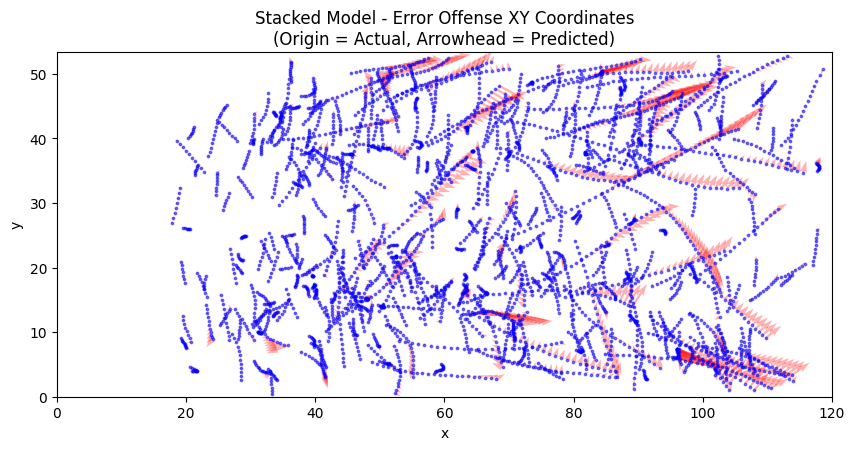

In [16]:
offense_quiver_plot = generate_quiver_plot(
    off_output_true_vs_preds['x_true'].values[0:5000],
    off_output_true_vs_preds['y_true'].values[0:5000],
    off_output_true_vs_preds['x_pred'].values[0:5000],
    off_output_true_vs_preds['y_pred'].values[0:5000],
    xlims=(0, 120),
    ylims=(0, 53.3),
    with_vhLines=False,
    title='Stacked Model - Error Offense XY Coordinates\n(Origin = Actual, Arrowhead = Predicted)'
)

In [17]:
offense_quiver_plot.savefig('figures/offense_quiver_plot.png')

#### Defense

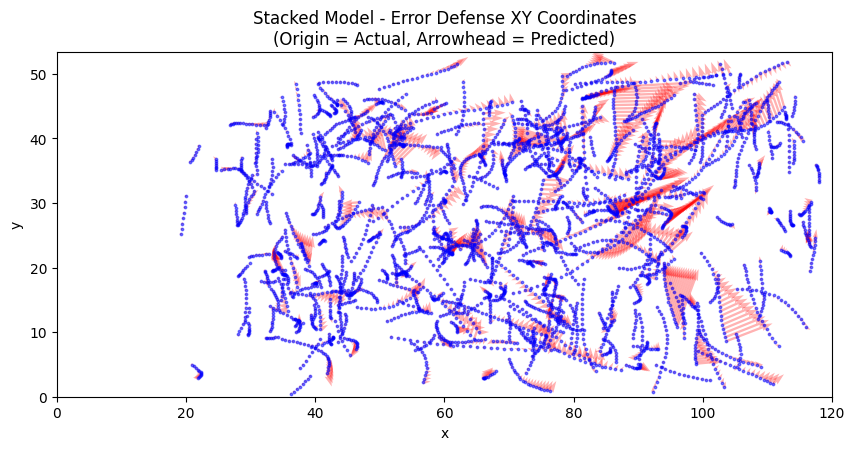

In [18]:
defense_quiver_plot = generate_quiver_plot(
    def_output_true_vs_preds['x_true'].values[0:5000],
    def_output_true_vs_preds['y_true'].values[0:5000],
    def_output_true_vs_preds['x_pred'].values[0:5000],
    def_output_true_vs_preds['y_pred'].values[0:5000],
    xlims=(0, 120),
    ylims=(0, 53.3),
    with_vhLines=False,
    title='Stacked Model - Error Defense XY Coordinates\n(Origin = Actual, Arrowhead = Predicted)'
)

In [19]:
defense_quiver_plot.savefig('figures/defense_quiver_plot.png')

## RMSE

In [70]:
def calculate_rmse(df: pd.DataFrame):
    df_no_nan = df.dropna(subset=['x_true', 'y_true']).copy()
    df_no_nan['x_diff_squared'] = (df_no_nan['x_true'] - df_no_nan['x_pred']) ** 2
    df_no_nan['y_diff_squared'] = (df_no_nan['y_true'] - df_no_nan['y_pred']) ** 2
    sum_squared_diff = sum(df_no_nan['x_diff_squared'] + df_no_nan['y_diff_squared'])
    rmse = np.sqrt(sum_squared_diff / (2 * len(df)))
    
    return rmse

#### All

In [71]:
calculate_rmse(output_true_vs_preds)

0.8687235710919995

#### Offense

In [72]:
calculate_rmse(off_output_true_vs_preds)

0.6503481951842894

#### Defense

In [73]:
calculate_rmse(def_output_true_vs_preds)

0.9422788276341719

In [74]:
# dill.dump_session('prediction_saved_session/completed.db')